# Example augmentation workflow

In machine learning, *augmentation* refers to creating or modifying data to supplement prexisting training data. Augmentation "messes up" the given training data to increase the size of the dataset, as well as to give more breadth in the hope of making the machine learning more robust. 

To augment data for machine learning on spectrograms, we perform "manipulations" on audio samples or spectrogram images. This example augmentation workflow uses code from two modules, `../code/audio_aug.py` and `../code/spectrogram_aug.py`. The modules are parallel: both define a class, `Audio` or `Spectrogram`. The class attributes include, among other things, a list of which manipulation functions have been called on the object.

Below we demonstrate augmentation of a single audio file. We will perform the same augmentation pipeline on 10 instances of this object. Many of the manipulation functions include randomness, resulting in 10 quite different looking spectrograms by the end of the process.

## Set up imports of augmentation code

In [1]:
import sys
import os
REPO_PATH = os.path.abspath('../..')
sys.path.append(REPO_PATH)

In [2]:
%load_ext autoreload

## Helper function

All augmentation functions have a similar structure. They are each called with one required argument (which should be either an `Audio` or a `Spectrogram` object) and several optional keyword arguments. The following class, InstList, allows us to apply manipulation functions in sequence on a set of audio objects, as demonstrated below.


In [3]:
from create_training_data.code.utils import InstList

## Audio manipulation
`audio_aug.py` includes the Audio class, which has the following attributes as pre-allocated in `__slots__`:

In [4]:
import create_training_data.code.audio_aug as aa
aa.Audio.__slots__

['original_path',
 'samples',
 'sample_rate',
 'possible_manipulations',
 'manipulations',
 'sources',
 'labels']

### Make 10 audio chunks from a file
Create one Audio object from an audio file. Then, create 10 deep copies of this Audio object. 

In [5]:
# Load audio file
audio_file_path = '../tests/1min.wav'
audio = aa.Audio(label = 'test', path = audio_file_path)

In [6]:
# Make 10 audio chunks from this file
from copy import deepcopy
audios = []
for _ in range(10):
    audios.append(deepcopy(audio))

### Apply Audio manipulation functions


Manipulations in the module operate on instances of this class. Some functions in the module start with an underscore--these are helper functions that are meant to be used only within the module itself; they may or may not operate on instances of the class.


In [7]:
def show_funcs_in_module(module):
    import types
    all_funcs = [getattr(module, a) for a in dir(module)
      if isinstance(getattr(module, a), types.FunctionType)]
    
    for func in all_funcs: print(func.__name__)

show_funcs_in_module(aa)

_audio_manipulation
_combine_samples
_divide_samples
_fade
_select_chunk
_shift_array
_sum_samples
_wraparound_extract
cyclic_shift
get_chunk
pitch_shift_divisions
random_filter
sum_chunks
time_stretch_divisions


Most of the manipulations below are called with default options. Any keyword arguments passed to `apply_func` will be passed directly to the function given as the first argument to `apply_func`. In our example below, we require a random skip by passing in a 1 for `aa.get_chunk`'s keyword argument `chance_random_skip`. A list of possible keyword arguments can be obtained via calling `help()` on the function, e.g. via `help(aa.get_chunk)`.


In [8]:
audio_list = InstList(instances = audios, obj_type = aa.Audio)
audio_list = audio_list \
    .apply_func(func = aa.get_chunk, chance_random_skip = 1) \
    .apply_func(func = aa.cyclic_shift) \
    .apply_func(func = aa.time_stretch_divisions) \
    .apply_func(func = aa.pitch_shift_divisions) \
    .apply_func(func = aa.random_filter) \
    .apply_func(func = aa.sum_chunks)

## Spectrogram manipulation
Again, the `Spectrogram` class includes attributes that are pre-allocated in `__slots__`.

In [9]:
import create_training_data.code.spectrogram_aug as sa
sa.Spectrogram.__slots__

['audio',
 'sample_rate',
 'samples',
 'labels',
 'mel',
 'spect_settings',
 'spect',
 'times',
 'freqs',
 'possible_manipulations',
 'manipulations',
 'sources']

### Turn the audios into spectrograms
This step creates `Spectrogrm` objects from the `Audio` objects, which does not actually compute the spectrogram. The spectrogram is computed separately to preserve parallelism of the API in terms of what manipulations are added to the `Spectrogram.manipulations` attribute. Either mel or linear spectrograms can be computed.

In [10]:
spects = []
for audio in audio_list:
    spects.append(sa.Spectrogram(
        audio = audio
    ))

### Apply Spectrogram manipulations

Again, our possible manipulations are as follows:

In [11]:
show_funcs_in_module(sa)

_remove_bands
_resize_bands
_spectrogram_manipulation
color_jitter
make_linear_spectrogram
make_mel_spectrogram
remove_random_hi_lo_bands
resize_random_bands
resize_spect_random_interpolation


Now we apply the manipulation functions, mostly with default values.

In [12]:
spect_list = InstList(instances = spects, obj_type = sa.Spectrogram)
spect_list = spect_list \
    .apply_func(func = sa.make_linear_spectrogram) \
    .apply_func(func = sa.remove_random_hi_lo_bands) \
    .apply_func(func = sa.resize_random_bands) \
    .apply_func(func = sa.resize_spect_random_interpolation) \
    .apply_func(
        func = sa.color_jitter,
        hue = None
    )

## Plot results

Below we define a small utility that plots all of the spectrograms using the `Spectrogram` method `plot_axes`.

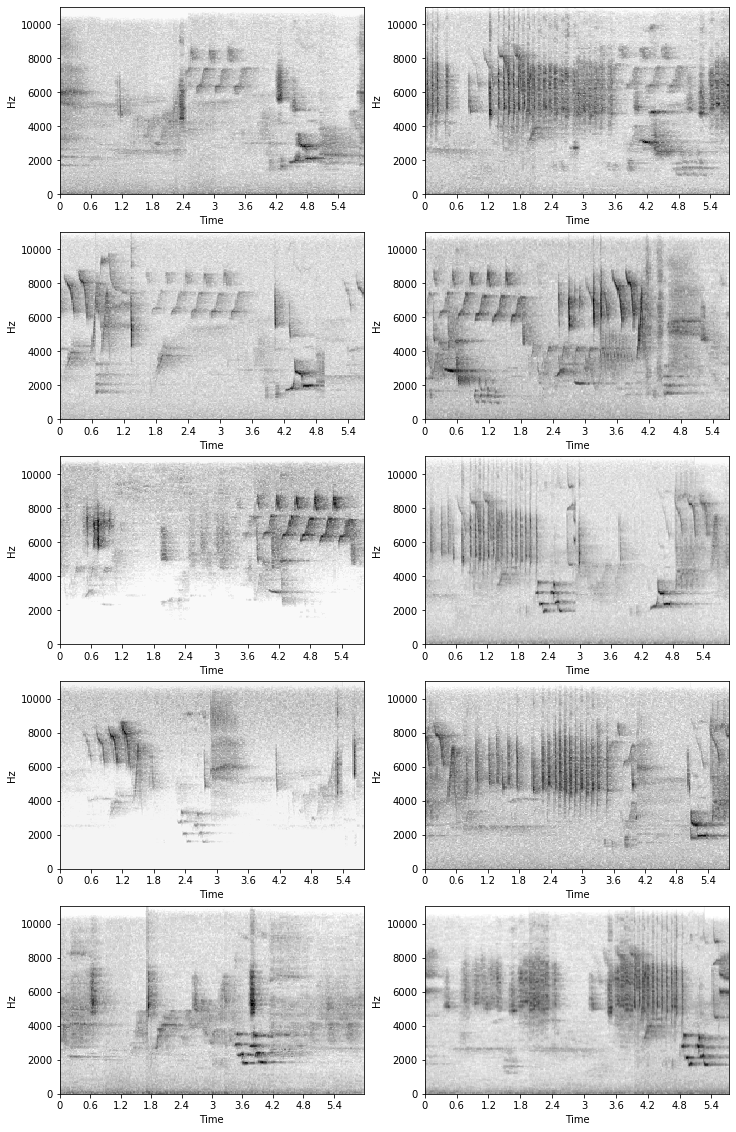

In [13]:
def plot_all(spect_list, size = (12, 20), width = 3):
    import matplotlib.pyplot as plt
    from math import ceil
    
    width = width
    height = ceil(len(spect_list) / width)

    fig, ax = plt.subplots(height, width, figsize = size)
    axes = ax.flatten() # Make accessible by single indices
    
    for idx, spect in enumerate(spect_list): 
        spect_ax = spect.plot_axes(ax = axes[idx])
    
    plt.show()
    
    return fig, ax

fig, ax = plot_all(spect_list, width = 2)